# JupyterLite で学ぶ scikit-learn 中級チュートリアル

このノートブックは、**JupyterLite（ブラウザだけで動く Jupyter 環境）** 上で、
scikit-learn の中級レベルの機能を学ぶためのチュートリアルです。

## 対象者
- scikit-learn の基礎（基本的なモデルの学習・評価）を理解している方
- アンサンブル学習やハイパーパラメータチューニングを学びたい方

## このチュートリアルで学ぶこと
1. アンサンブル学習（ランダムフォレスト、勾配ブースティング）
2. ハイパーパラメータチューニング
3. パイプライン
4. 特徴量選択
5. クラスタリング
6. 次元削減
7. モデルの保存と読み込み

## 0. 環境準備（JupyterLite 用）

まず、必要なライブラリをインストールします。

In [1]:
# JupyterLite 用のパッケージインストール
try:
    import piplite
    await piplite.install(['numpy', 'pandas', 'matplotlib', 'scikit-learn'])
except ImportError:
    pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
print(f'scikit-learn バージョン: {sklearn.__version__}')

# 警告を抑制
import warnings
warnings.filterwarnings('ignore')

# 乱数シード
np.random.seed(42)

scikit-learn バージョン: 1.7.2


In [2]:
# サンプルデータの読み込み
from sklearn.datasets import load_iris, load_wine, load_diabetes, make_blobs, make_moons

iris = load_iris()
wine = load_wine()
diabetes = load_diabetes()

print('データセット読み込み完了')

データセット読み込み完了


---
## 1. アンサンブル学習

### 1.1 ランダムフォレスト

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# データ準備
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ランダムフォレスト
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(f'正解率: {accuracy_score(y_test, y_pred):.4f}')

正解率: 1.0000


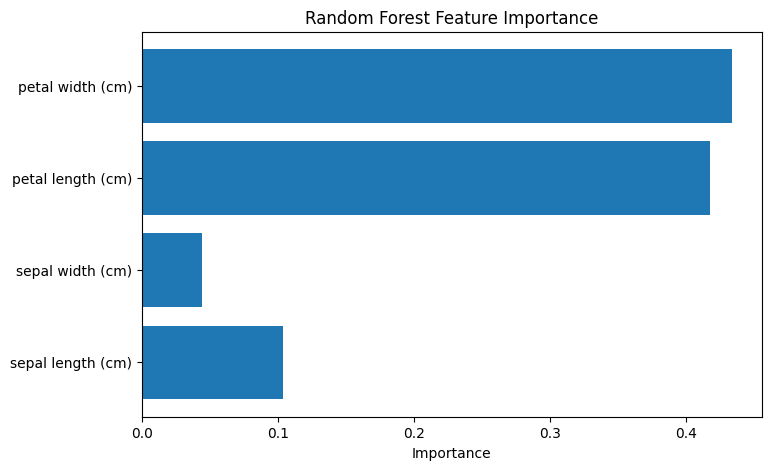

In [4]:
# 特徴量の重要度
importance = rf_model.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(iris.feature_names, importance)
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

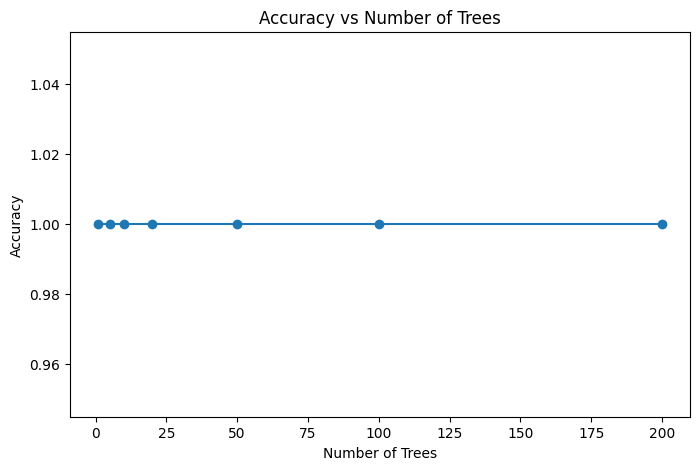

In [5]:
# 木の数による精度の変化
n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
scores = []

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, scores, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees')
plt.show()

### 1.2 勾配ブースティング

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# 勾配ブースティング
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
print(f'正解率: {accuracy_score(y_test, y_pred):.4f}')

正解率: 1.0000


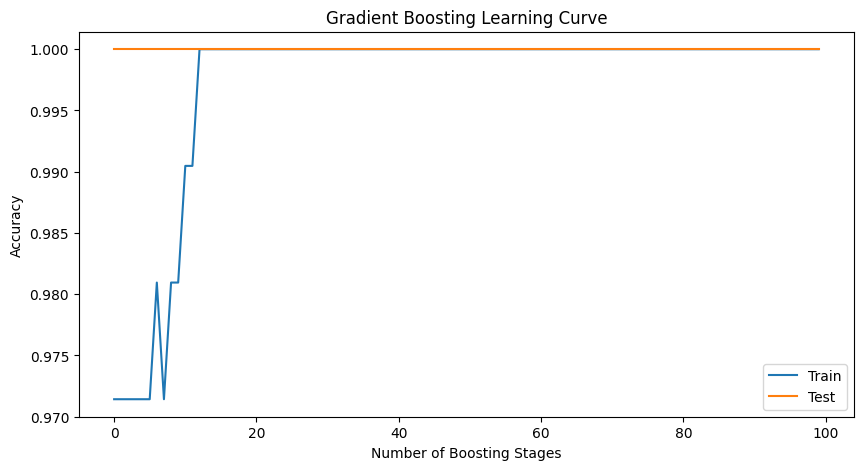

In [7]:
# 学習曲線（ステージごとの精度）
train_scores = []
test_scores = []

for i, y_pred_train in enumerate(gb_model.staged_predict(X_train)):
    train_scores.append(accuracy_score(y_train, y_pred_train))

for i, y_pred_test in enumerate(gb_model.staged_predict(X_test)):
    test_scores.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(train_scores, label='Train')
plt.plot(test_scores, label='Test')
plt.xlabel('Number of Boosting Stages')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.show()

### 1.3 アンサンブル手法の比較

In [8]:
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f'{name}: {scores.mean():.4f} (+/- {scores.std():.4f})')

Decision Tree: 0.9533 (+/- 0.0340)
Bagging: 0.9533 (+/- 0.0340)


Random Forest: 0.9667 (+/- 0.0211)


AdaBoost: 0.9533 (+/- 0.0340)


Gradient Boosting: 0.9600 (+/- 0.0327)


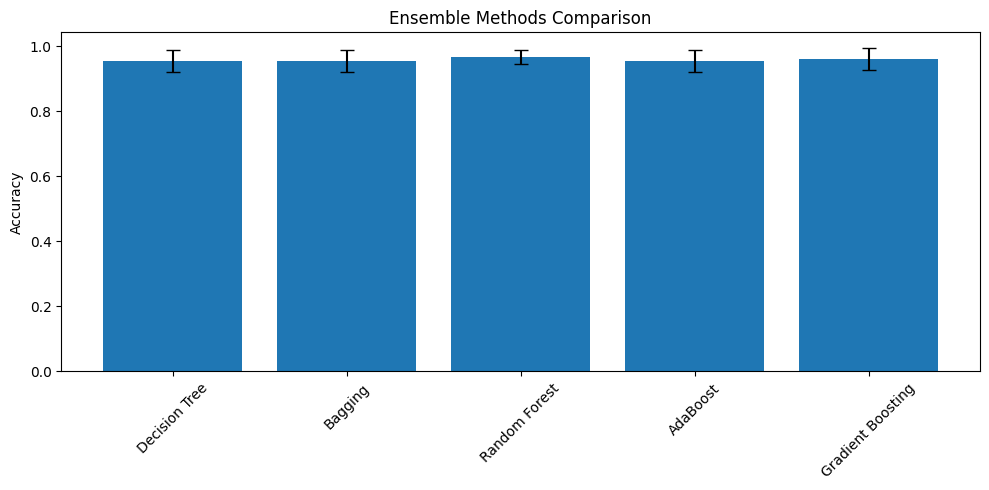

In [9]:
# 比較の可視化
names = list(results.keys())
means = [results[name]['mean'] for name in names]
stds = [results[name]['std'] for name in names]

plt.figure(figsize=(10, 5))
plt.bar(names, means, yerr=stds, capsize=5)
plt.ylabel('Accuracy')
plt.title('Ensemble Methods Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 2. ハイパーパラメータチューニング

### 2.1 グリッドサーチ

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# パラメータグリッド
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# グリッドサーチ
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('=== グリッドサーチ結果 ===')
print(f'最良パラメータ: {grid_search.best_params_}')
print(f'最良スコア: {grid_search.best_score_:.4f}')

=== グリッドサーチ結果 ===
最良パラメータ: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
最良スコア: 0.9619


In [11]:
# 結果の詳細
results_df = pd.DataFrame(grid_search.cv_results_)
print('\n上位5件:')
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
      .sort_values('rank_test_score')
      .head())


上位5件:
                                         params  mean_test_score  \
7   {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}         0.961905   
9    {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}         0.961905   
11     {'C': 1, 'gamma': 1, 'kernel': 'linear'}         0.961905   
15  {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}         0.952381   
12    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}         0.952381   

    std_test_score  rank_test_score  
7         0.035635                1  
9         0.035635                1  
11        0.035635                1  
15        0.042592                4  
12        0.042592                4  


In [12]:
# 最良モデルでテスト
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'テスト精度: {accuracy_score(y_test, y_pred):.4f}')

テスト精度: 1.0000


### 2.2 ランダムサーチ

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# パラメータ分布
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# ランダムサーチ
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print('=== ランダムサーチ結果 ===')
print(f'最良パラメータ: {random_search.best_params_}')
print(f'最良スコア: {random_search.best_score_:.4f}')

=== ランダムサーチ結果 ===
最良パラメータ: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}
最良スコア: 0.9429


---
## 3. パイプライン

### 3.1 基本的なパイプライン

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# パイプラインの作成
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# 学習
pipeline.fit(X_train, y_train)

# 予測
y_pred = pipeline.predict(X_test)
print(f'正解率: {accuracy_score(y_test, y_pred):.4f}')

正解率: 1.0000


### 3.2 パイプラインとグリッドサーチ

In [15]:
# パイプラインのパラメータチューニング
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'最良パラメータ: {grid_search.best_params_}')
print(f'最良スコア: {grid_search.best_score_:.4f}')

最良パラメータ: {'svm__C': 1, 'svm__gamma': 0.1}
最良スコア: 0.9524


### 3.3 make_pipeline

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# 簡潔な書き方
pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
)

pipe.fit(X_train, y_train)
print(f'正解率: {pipe.score(X_test, y_test):.4f}')
print(f'パイプラインのステップ: {pipe.steps}')

正解率: 0.9111
パイプラインのステップ: [('standardscaler', StandardScaler()), ('pca', PCA(n_components=2)), ('logisticregression', LogisticRegression())]


### 3.4 ColumnTransformer

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 混合データの作成
df = pd.DataFrame({
    'age': [25, 30, 35, 40, 45],
    'income': [30000, 50000, 70000, 90000, 110000],
    'gender': ['M', 'F', 'M', 'F', 'M'],
    'education': ['High School', 'Bachelor', 'Master', 'PhD', 'Bachelor']
})

print('混合データ:')
print(df)

混合データ:
   age  income gender    education
0   25   30000      M  High School
1   30   50000      F     Bachelor
2   35   70000      M       Master
3   40   90000      F          PhD
4   45  110000      M     Bachelor


In [18]:
# 列ごとに異なる前処理
numeric_features = ['age', 'income']
categorical_features = ['gender', 'education']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# 変換
X_transformed = preprocessor.fit_transform(df)
print(f'変換後の形状: {X_transformed.shape}')
print(f'変換後のデータ:\n{X_transformed}')

変換後の形状: (5, 8)
変換後のデータ:
[[-1.41421356 -1.41421356  0.          1.          0.          1.
   0.          0.        ]
 [-0.70710678 -0.70710678  1.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   1.          0.        ]
 [ 0.70710678  0.70710678  1.          0.          0.          0.
   0.          1.        ]
 [ 1.41421356  1.41421356  0.          1.          1.          0.
   0.          0.        ]]


---
## 4. 特徴量選択

### 4.1 分散による選択

In [19]:
from sklearn.feature_selection import VarianceThreshold

# サンプルデータ（低分散の特徴量を含む）
X_sample = np.array([[1, 0, 0.1],
                     [2, 0, 0.2],
                     [3, 0, 0.3],
                     [4, 0, 0.4],
                     [5, 0, 0.5]])

print(f'元のデータ形状: {X_sample.shape}')
print(f'各列の分散: {X_sample.var(axis=0)}')

# 分散が閾値以下の特徴量を削除
selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(X_sample)

print(f'選択後の形状: {X_selected.shape}')

元のデータ形状: (5, 3)
各列の分散: [2.   0.   0.02]
選択後の形状: (5, 1)


### 4.2 単変量特徴量選択

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# iris データセット
X = iris.data
y = iris.target

# 上位2つの特徴量を選択
selector = SelectKBest(f_classif, k=2)
X_selected = selector.fit_transform(X, y)

print(f'元の特徴量: {iris.feature_names}')
print(f'選択された特徴量: {np.array(iris.feature_names)[selector.get_support()]}')
print(f'各特徴量のスコア: {selector.scores_}')

元の特徴量: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
選択された特徴量: ['petal length (cm)' 'petal width (cm)']
各特徴量のスコア: [ 119.26450218   49.16004009 1180.16118225  960.0071468 ]


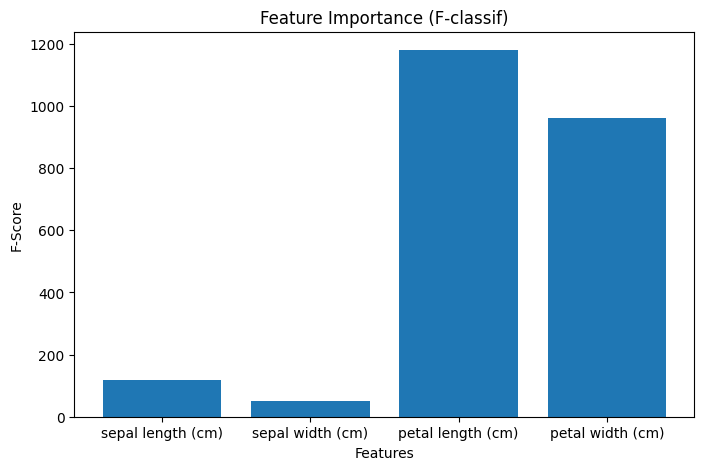

In [21]:
# スコアの可視化
plt.figure(figsize=(8, 5))
plt.bar(iris.feature_names, selector.scores_)
plt.xlabel('Features')
plt.ylabel('F-Score')
plt.title('Feature Importance (F-classif)')
plt.show()

### 4.3 再帰的特徴量削減（RFE）

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# RFE
model = LogisticRegression(max_iter=200)
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X, y)

print('RFE による特徴量選択:')
for name, selected, ranking in zip(iris.feature_names, rfe.support_, rfe.ranking_):
    print(f'  {name}: 選択={selected}, ランク={ranking}')

RFE による特徴量選択:
  sepal length (cm): 選択=False, ランク=3
  sepal width (cm): 選択=False, ランク=2
  petal length (cm): 選択=True, ランク=1
  petal width (cm): 選択=True, ランク=1


---
## 5. クラスタリング

### 5.1 K-means

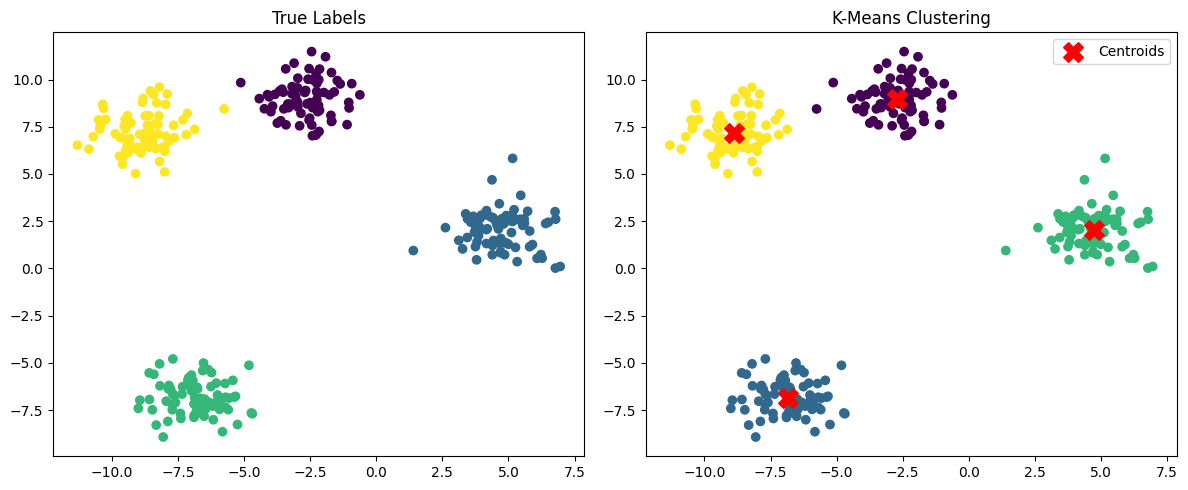

In [23]:
from sklearn.cluster import KMeans

# サンプルデータ生成
X_cluster, y_true = make_blobs(n_samples=300, centers=4, random_state=42)

# K-means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_cluster)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 真のラベル
axes[0].scatter(X_cluster[:, 0], X_cluster[:, 1], c=y_true, cmap='viridis')
axes[0].set_title('True Labels')

# K-means結果
axes[1].scatter(X_cluster[:, 0], X_cluster[:, 1], c=y_kmeans, cmap='viridis')
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='X', s=200, label='Centroids')
axes[1].set_title('K-Means Clustering')
axes[1].legend()

plt.tight_layout()
plt.show()

### 5.2 エルボー法

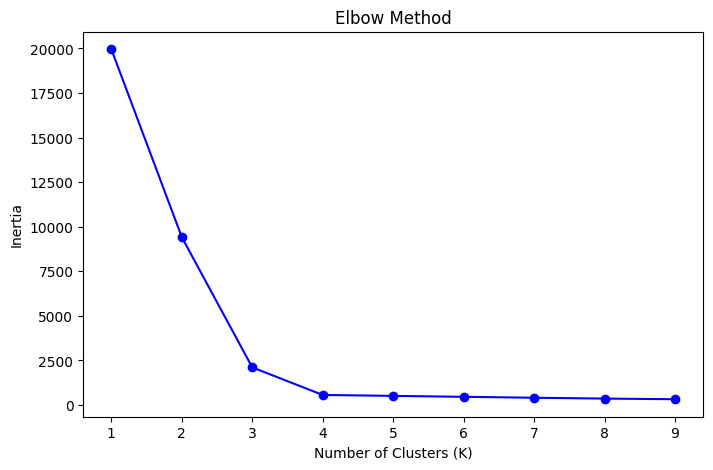

In [24]:
# 最適なクラスタ数を探す
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### 5.3 シルエットスコア

K=2: シルエットスコア = 0.5902
K=3: シルエットスコア = 0.7569


K=4: シルエットスコア = 0.7916
K=5: シルエットスコア = 0.6890


K=6: シルエットスコア = 0.5514
K=7: シルエットスコア = 0.4297


K=8: シルエットスコア = 0.3369
K=9: シルエットスコア = 0.3502


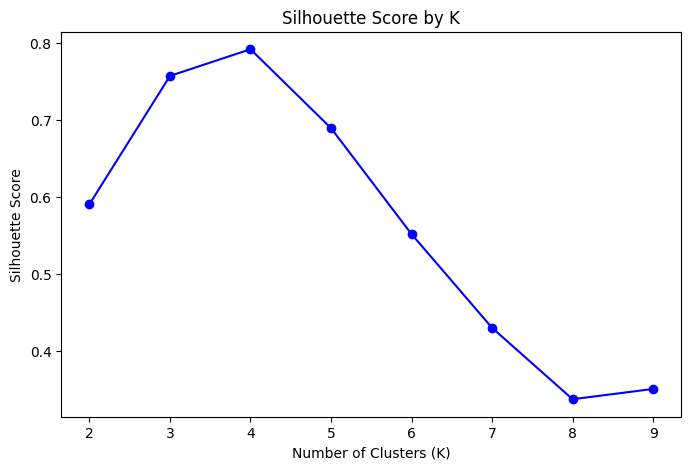

In [25]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    silhouette_scores.append(score)
    print(f'K={k}: シルエットスコア = {score:.4f}')

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.show()

### 5.4 DBSCAN

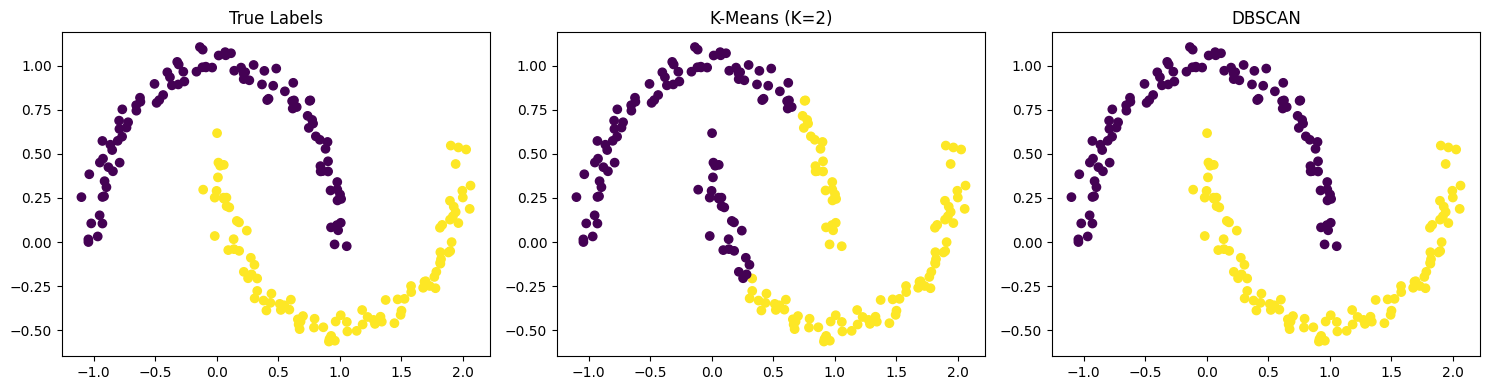

In [26]:
from sklearn.cluster import DBSCAN

# 月形のデータ
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=42)

# K-means vs DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 真のラベル
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis')
axes[0].set_title('True Labels')

# K-means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_moons)
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, cmap='viridis')
axes[1].set_title('K-Means (K=2)')

# DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons)
axes[2].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_dbscan, cmap='viridis')
axes[2].set_title('DBSCAN')

plt.tight_layout()
plt.show()

---
## 6. 次元削減

### 6.1 主成分分析（PCA）

In [27]:
from sklearn.decomposition import PCA

# iris データセット
X = iris.data
y = iris.target

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 寄与率
print('各主成分の寄与率:')
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f'  PC{i+1}: {ratio:.4f}')
print(f'累積寄与率: {pca.explained_variance_ratio_.cumsum()}')

各主成分の寄与率:
  PC1: 0.7296
  PC2: 0.2285
  PC3: 0.0367
  PC4: 0.0052
累積寄与率: [0.72962445 0.95813207 0.99482129 1.        ]


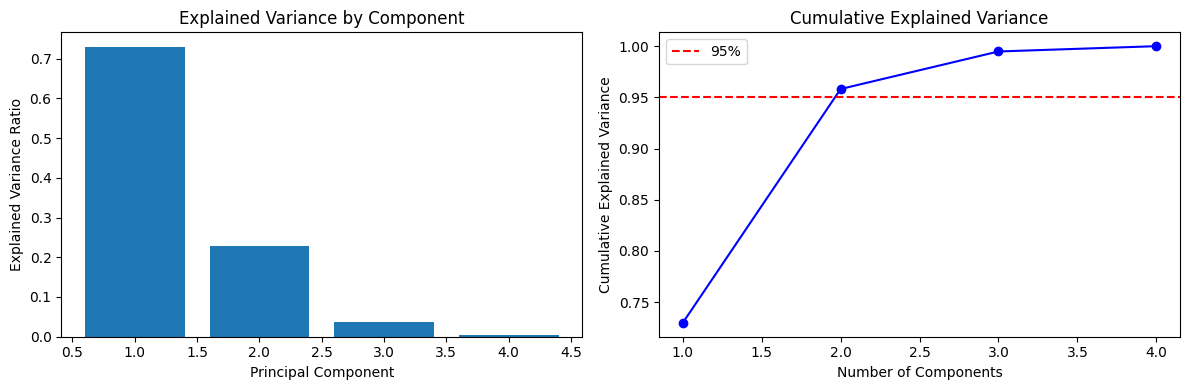

In [28]:
# 寄与率の可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 各成分の寄与率
axes[0].bar(range(1, 5), pca.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Component')

# 累積寄与率
axes[1].plot(range(1, 5), pca.explained_variance_ratio_.cumsum(), 'bo-')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.show()

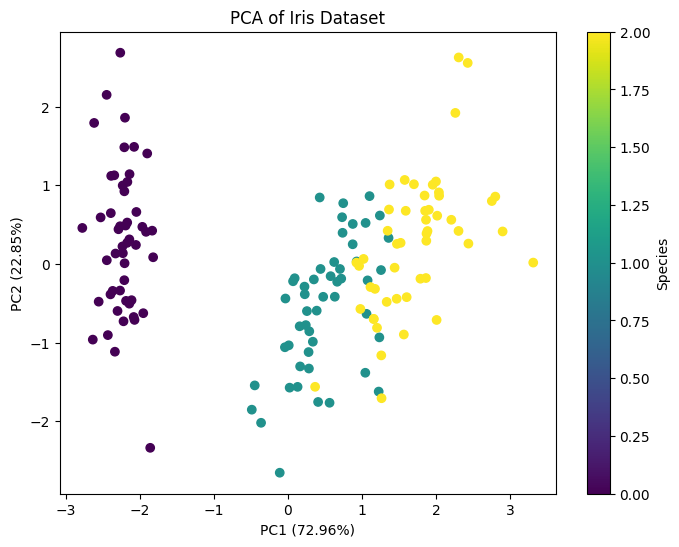

In [29]:
# 2次元にプロット
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
plt.title('PCA of Iris Dataset')
plt.colorbar(scatter, label='Species')
plt.show()

### 6.2 t-SNE

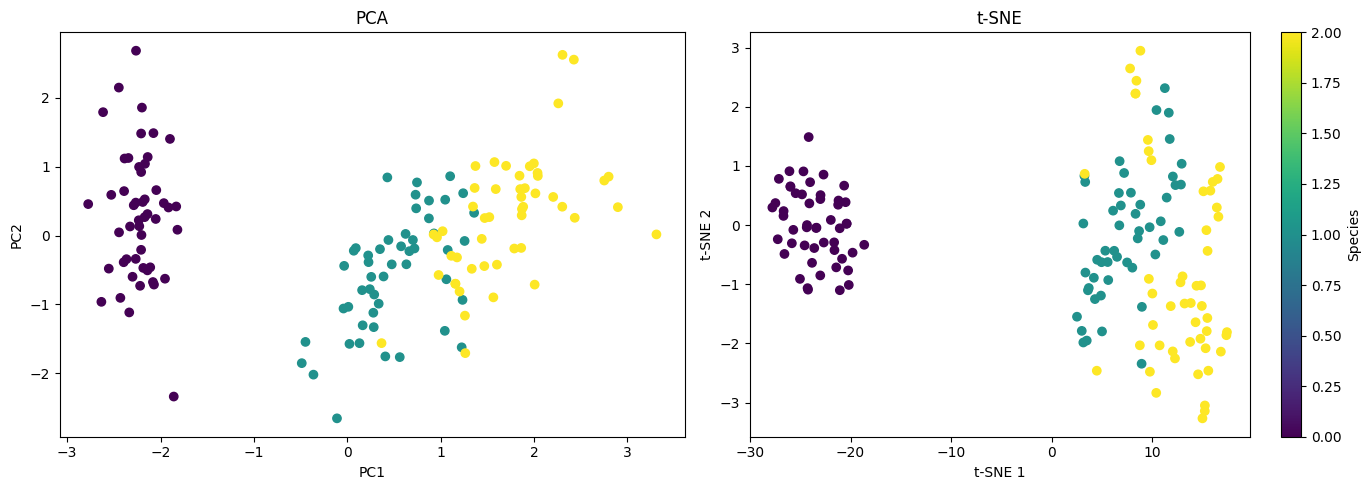

In [30]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# PCA vs t-SNE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA')

# t-SNE
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE')

plt.colorbar(scatter2, ax=axes[1], label='Species')
plt.tight_layout()
plt.show()

---
## 7. モデルの保存と読み込み

In [31]:
import pickle
import json

# モデルの学習
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f'元のモデル精度: {model.score(X_test, y_test):.4f}')

元のモデル精度: 1.0000


In [32]:
# pickle で保存
with open('/tmp/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 読み込み
with open('/tmp/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(f'読み込んだモデル精度: {loaded_model.score(X_test, y_test):.4f}')

読み込んだモデル精度: 1.0000


In [33]:
# joblib を使う方法（推奨）
try:
    from joblib import dump, load
    
    # 保存
    dump(model, '/tmp/model.joblib')
    
    # 読み込み
    loaded_model = load('/tmp/model.joblib')
    print(f'joblib で読み込んだモデル精度: {loaded_model.score(X_test, y_test):.4f}')
except ImportError:
    print('joblib が利用できません')

joblib で読み込んだモデル精度: 1.0000


### 📝 7章 練習問題

wine データセットを使って以下を実行してください。

1. StandardScaler、PCA（n_components=5）、RandomForestClassifier を含むパイプラインを作成
2. RandomForestのn_estimatorsを[50, 100, 200]でグリッドサーチ
3. 最良のモデルでテストデータを評価

In [34]:
# 練習問題の解答欄



---
## まとめ

このチュートリアルで学んだことをまとめます：

| トピック | 主なクラス・関数 |
|---------|---------------|
| アンサンブル学習 | `RandomForestClassifier`, `GradientBoostingClassifier`, `AdaBoostClassifier` |
| ハイパーパラメータ | `GridSearchCV`, `RandomizedSearchCV` |
| パイプライン | `Pipeline`, `make_pipeline`, `ColumnTransformer` |
| 特徴量選択 | `SelectKBest`, `RFE`, `VarianceThreshold` |
| クラスタリング | `KMeans`, `DBSCAN`, `silhouette_score` |
| 次元削減 | `PCA`, `TSNE` |
| モデル保存 | `pickle`, `joblib` |

## 次のステップ

scikit-learn の中級を終えたら、以下も学んでみましょう：
- **XGBoost / LightGBM**: 高性能な勾配ブースティング
- **深層学習**: TensorFlow / PyTorch
- **AutoML**: 自動機械学習ツール